In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn, likelihood_nn
from sbi.neural_nets.embedding_nets import FCEmbedding
from CosmoFuse.visualisation import make_corner_plot
import wandb
from tarp import get_tarp_coverage

device="cuda:0"
rng = np.random.default_rng(12345)

2024-04-30 14:51:43.327663: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 14:51:43.327741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 14:51:43.330554: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 14:51:43.348930: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 14:51:48.310691: W tensorflow/comp

In [2]:
min_scale = 6 

theta = np.load('../data/run2/theta.npy')[:,:2] # [Om, s8, w, n_s, Ob, H0]

xip = np.load('../data/run2/xip.npy')
xim = np.load('../data/run2/xim.npy')
xi = np.concatenate((xip[:,:,min_scale:,None], xim[:,:,min_scale:,None]), axis=3)
xi_flat = xi.reshape(xi.shape[0], -1)


base_path_fiducial = '/e/ocean1/users/dgebauer/sbi/measurements/fiducial/'
xip_fiducial = np.load(base_path_fiducial + 'xip.npy').reshape(800, 10, 15)[:,:,min_scale:].reshape(800,-1)
xim_fiducial = np.load(base_path_fiducial + 'xim.npy').reshape(800, 10, 15)[:,:,min_scale:].reshape(800,-1)
xi_fiducial = np.concatenate((xip_fiducial, xim_fiducial), axis=1)


cov = np.cov(xi_fiducial.T)
noise = rng.multivariate_normal(np.zeros(xi_fiducial.shape[1]), cov, xi_flat.shape[0])
xi_flat += noise


x = xi_flat

y = theta

val_inds = np.random.choice(np.arange(x.shape[0]), size=int(x.shape[0]*0.1), replace=False)
test_inds = np.random.choice(np.arange(x.shape[0]), size=int(x.shape[0]*0.1), replace=False)
y_val = y[val_inds]
y_test = y[test_inds]
y_train = np.delete(y, [val_inds, test_inds], axis=0)
x_val = x[val_inds]
x_test = x[test_inds]
x_train = np.delete(x, [val_inds, test_inds], axis=0)



x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
y_test = np.concatenate([y_test[:,0, None], (y_test[:,1]*np.sqrt(y_test[:,0]/0.3))[:,None], y_test[:,1, None]], axis=1)

print(f"N_train={x_train.shape[0]}, N_val={x_val.shape[0]}, N_test={x_test.shape[0]}\n")



param_names = [r'$\Omega_m$', r'$\sigma_8$', r'$S_8$']
prior = utils.BoxUniform(low=torch.tensor([y.min(axis=0)]), high=torch.tensor([y.max(axis=0)]), device=device)
_, prior = prepare_for_sbi(lambda foo: 0, prior)



N_train=161998, N_val=20000, N_test=20000



/tmp/ipykernel_140865/263260566.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  prior = utils.BoxUniform(low=torch.tensor([y.min(axis=0)]), high=torch.tensor([y.max(axis=0)]), device=device)
/home/moon/dgebauer/anaconda3/envs/sbi/lib/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [3]:
embedding_net = FCEmbedding(input_dim=x_train.shape[1], output_dim=5, num_layers=4, num_hiddens=128)
density_estimator_custom = posterior_nn(model="maf", num_transforms=5, embedding_net=embedding_net, hidden_features=64, num_blocks=3, device=device)
inference = SNPE(density_estimator=density_estimator_custom, prior=prior, device=device)
density_estimator = inference.append_simulations(y_train, x_train).train(show_train_summary=True, stop_after_epochs=20, training_batch_size=100, learning_rate=1e-4)
posterior = inference.build_posterior(density_estimator)

/home/moon/dgebauer/anaconda3/envs/sbi/lib/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


 Training neural network. Epochs trained: 15

In [ ]:
eval_ind = np.array([np.linalg.norm(x+y) for (x,y) in np.abs(y_test[:,(0,2)]-np.array([[0.26, 0.84]]))]).argsort()[:100]

samples = []
for i in range(100):
    sample_i = posterior.sample((1000000,), x=x_test[eval_ind[i]]).detach().cpu().numpy()
    samples.append(np.concatenate([sample_i[:,0, None], (sample_i[:,1]*np.sqrt(sample_i[:,0]/0.3))[:,None], sample_i[:,1, None]], axis=1))

samples = np.array(samples)
sample_y = y_test[eval_ind]

Drawing 10000000 posterior samples:   0%|          | 0/10000000 [00:00<?, ?it/s]

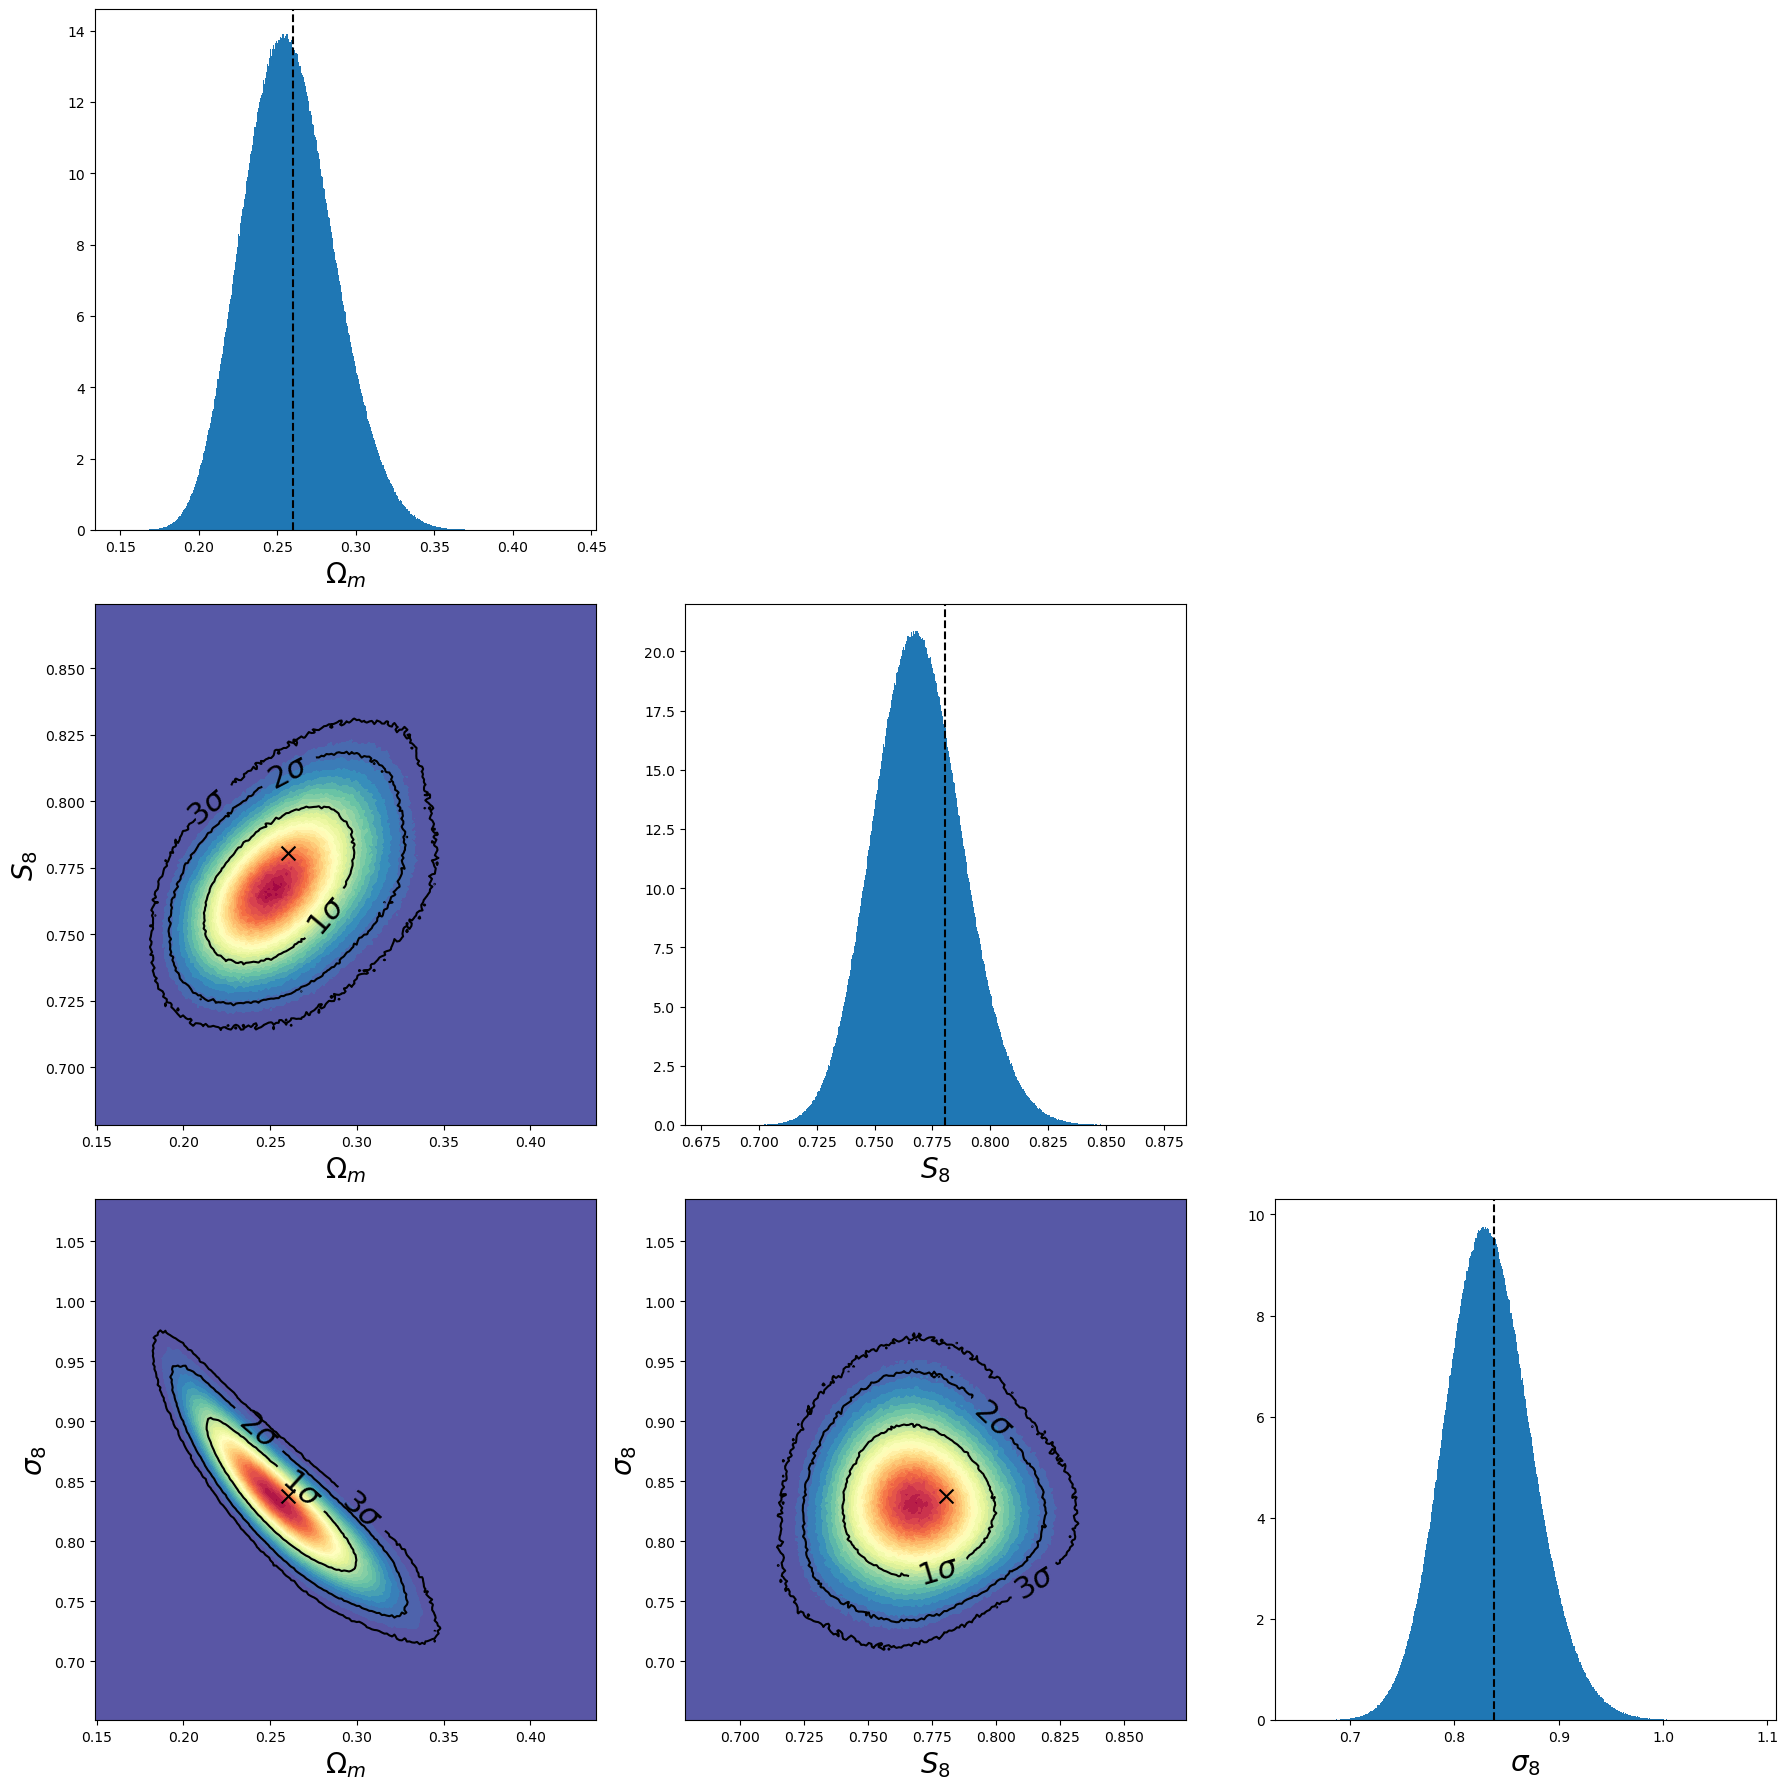

In [ ]:
param_names = [r'$\Omega_m$', r'$S_8$', r'$\sigma_8$']

_ = make_corner_plot(samples[0], theta_obs=y_test[eval_ind[0]], param_names=param_names, smooth=.2)

In [ ]:
samples.shape, y_test[eval_ind].shape

In [ ]:
#samples = samples.transpose(1,0,2)

get_tarp_coverage(samples, y_test[eval_ind], bootstrap=True, num_bootstrap=10)